Epoch 1/10
1563/1563 [==============================] - 77s 46ms/step - loss: 0.2908 - accuracy: 0.8948 - val_loss: 0.3254 - val_accuracy: 0.9000
Epoch 2/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.2468 - accuracy: 0.9042 - val_loss: 0.2786 - val_accuracy: 0.9028
Epoch 3/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.2286 - accuracy: 0.9090 - val_loss: 0.2359 - val_accuracy: 0.9103
Epoch 4/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.2184 - accuracy: 0.9132 - val_loss: 0.2303 - val_accuracy: 0.9134
Epoch 5/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.2073 - accuracy: 0.9168 - val_loss: 0.2398 - val_accuracy: 0.9134
Epoch 6/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.1970 - accuracy: 0.9194 - val_loss: 0.2239 - val_accuracy: 0.9140
Epoch 7/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.1850 - accuracy: 0.9232 - val_loss: 0.2282 -

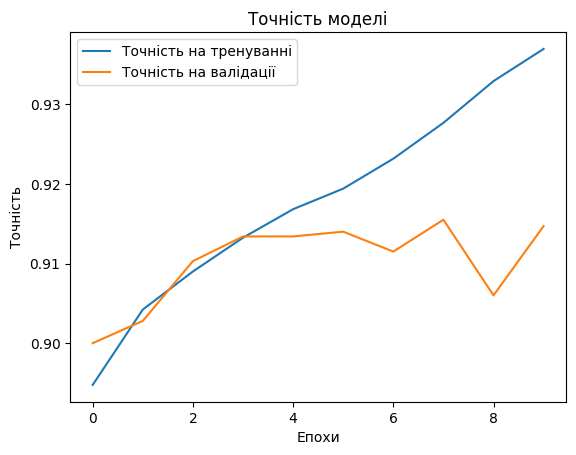

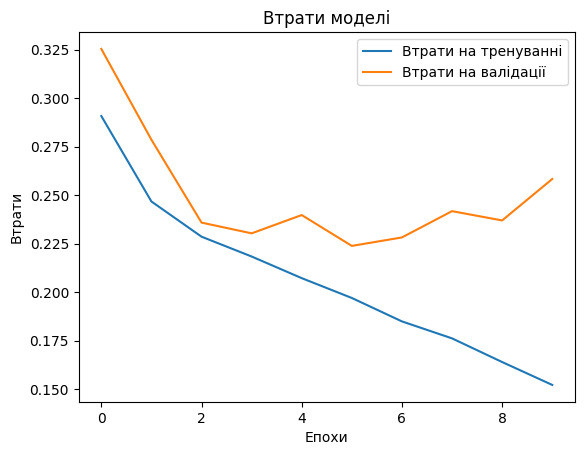

313/313 [==============================] - 7s 19ms/step


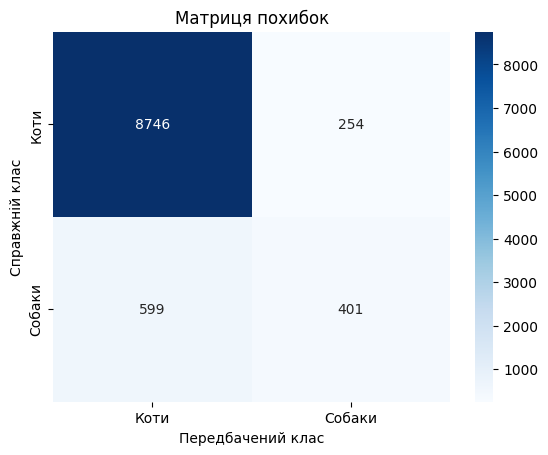

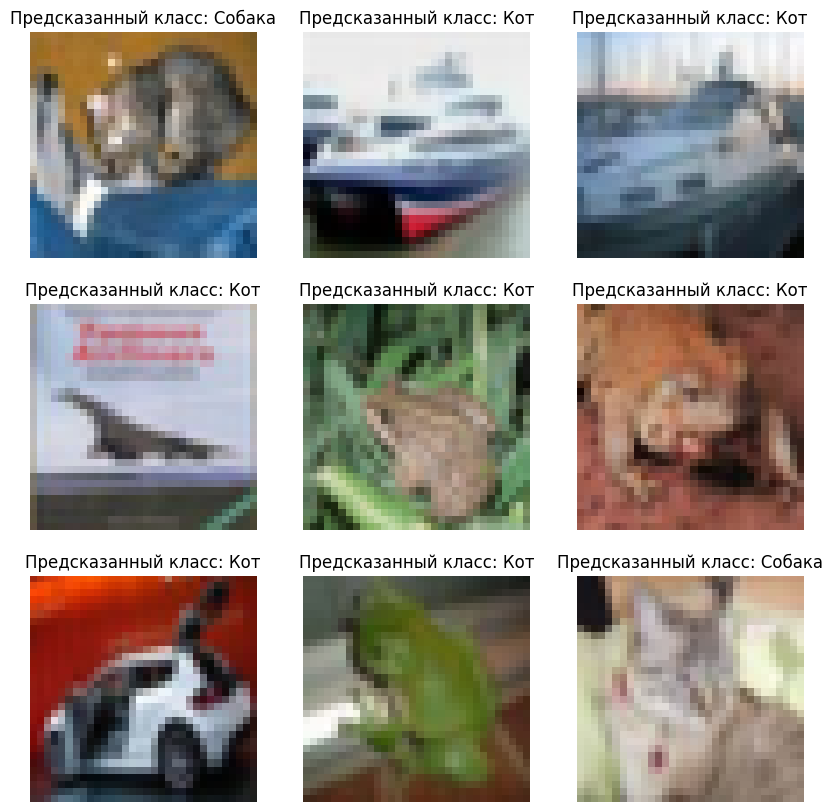

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split

# 1. Завантаження та підготовка даних (CIFAR-10)
# Завантаження CIFAR-10 датасету
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Нормалізація зображень (масштабування до діапазону [0, 1])
X_train, X_test = X_train / 255.0, X_test / 255.0

# Переведення міток на бінарні (коти = 0, собаки = 1)
y_train_bin = np.where(y_train == 3, 1, 0)  # Коти (3) та собаки (5) у CIFAR-10
y_test_bin = np.where(y_test == 3, 1, 0)

# 2. Завантаження натренованої моделі MobileNetV2 з TensorFlow Hub
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 3. Адаптація моделі
# Заморожуємо всі шари базової моделі
base_model.trainable = False

# Створюємо нову модель
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Пулінг для зменшення розміру
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Бінарна класифікація (коти/собаки)
])

# 4. Fine-tuning: розморожуємо верхні шари базової моделі
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 5. Компільовуємо модель
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 6. Тренування моделі
history = model.fit(X_train, y_train_bin, epochs=10, batch_size=32, validation_data=(X_test, y_test_bin))

# 7. Оцінка моделі на тестових даних
test_loss, test_acc = model.evaluate(X_test, y_test_bin)
print(f'Тестова точність: {test_acc*100:.2f}%')

# 8. Візуалізація результатів
# Точність на тренуванні та валідації
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()
plt.show()

# Втрати на тренуванні та валідації
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# 9. Побудова матриці похибок
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Прогнозування класів
cm = confusion_matrix(y_test_bin, y_pred)

# Візуалізація матриці похибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Коти', 'Собаки'], yticklabels=['Коти', 'Собаки'])
plt.title('Матриця похибок')
plt.xlabel('Передбачений клас')
plt.ylabel('Справжній клас')
plt.show()

# 10. Візуалізація зображень із тестового набору та передбачені класи
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Предсказанный класс: {'Собака' if y_pred[i] == 1 else 'Кот'}")
    plt.axis("off")
plt.show()
